# Training a CNN in TensorFlow for cloud gap filling

Based on Tylere's tutorial https://github.com/tylere/ee-jupyter-examples/blob/master/4 - Earth Engine and TensorFlow.ipynb

In [2]:
import ee
from IPython import display
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
# import zipfile

ee.Initialize()

In [32]:
path_clear = 'C:/Users/ipdavies/CPR/data/images/clear_4337_LC08_026038_20160325'
path_clouds = 'C:/Users/ipdavies/CPR/data/images/clouds_4337_LC08_026038_20160325'
model_name = 'cnn2'
model_path = 'C:/Users/ipdavies/CPR/data/models/'+model_name+'/'

In [3]:
# Stack exported tifs from GEE into one multiband tif
import rasterio
import os

path = '../data/images/clear_4337_LC08_026038_20160325'

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

file_list = []
for file in listdir_fullpath(path):
    if file.endswith('.tif'):
        file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order

#=========== Want to rearrange the order of files so that target feature is last

# Create list of features with target feature (flooded) last
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])
    
# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# Make new directory for stacked tif if it doesn't already exist
try:
    os.mkdir(path+'/stack')
except OSError:
    pass

# Remove stack file if already exists
try:
    os.remove(path + '/stack/stack.tif')
except OSError:
    pass

with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [4]:
# Preprocess the data

# Get local image
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN

# Convert -999999 to None
data[data == -999999] = np.nan

# Get indices of non-nan values. These are the indices of the original image array
# data_ind = np.where(data[:,:,1] != None)
data_ind = np.where(~np.isnan(data[:,:,1]))
row, col = zip(np.where(~np.isnan(data[:,:,1]))) # image row and col of values
len(*row)


14000674

In [5]:
HOLDOUT_FRACTION = 0.1

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
data_vector.shape

# Select only the valid data and shuffle it.
# valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
# np.random.shuffle(data_vector)

# Hold out a fraction of the labeled data for validation.
training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
training_data = data_vector[0:training_size,:]
validation_data = data_vector[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands.
data_mean = training_data[:,0:14].mean(0)
data_std = training_data[:,0:14].std(0)

### Exploratory analysis of our dataset

In [6]:
# How imbalanced is our dataset? Flooded vs. non-flooded pixels
np.sum(data_vector[:,14]==1)/np.sum(data_vector[:,14]==0)*100

4.171495527091321

### Training the CNN

In [7]:
# Build TF model
def make_nn_layer(input, output_size):
    input_size = input.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal(
        [input_size, output_size],
        stddev=1.0 / math.sqrt(float(input_size))))
    biases = tf.Variable(tf.zeros([output_size]))
    return tf.matmul(input, weights) + biases

In [8]:
# These are all hyperparameters that need to be tuned?
NUM_INPUT_BANDS = 14
NUM_HIDDEN_1 = 15
NUM_HIDDEN_2 = 15
NUM_CLASSES = 2

input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
labels = tf.placeholder(tf.float32, shape=[None])

normalized = (input - data_mean) / data_std
hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1))
hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2))
logits = make_nn_layer(hidden2, NUM_CLASSES)
outputs = tf.argmax(logits, 1)

int_labels = tf.to_int64(labels)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # should we minimize something else?

correct_prediction = tf.equal(outputs, int_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Want to add recall/precision to this but can do that later
# https://stackoverflow.com/questions/46409626/how-to-properly-use-tf-metrics-accuracy

import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


In [9]:
# Train the neural net

# Had to alter some config and runoptions because kept running into OOM at last step during eval 
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)

config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

# import logging
# tf.logging.set_verbosity(tf.logging.INFO)

flooded = feat_list_files.index('flooded')
BATCH_SIZE = 1000
NUM_BATCHES = 1000

start_time = time.time()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer(), options=run_options)
    
    training_dict = {
        input: training_data[:,0:14],
        labels: training_data[:,14],
    }

    validation_dict = {
        input: validation_data[:,0:14],
        labels: validation_data[:,14],
    }

    for i in range(NUM_BATCHES):
        batch = training_data[np.random.choice(training_size, BATCH_SIZE, False),:]
        train_step.run({input: batch[:,0:14], labels: batch[:,14]})

        if i % 100 == 0 or i == NUM_BATCHES - 1:
#             print('Accuracy %.2f%% at step %d' % (accuracy.eval(validation_dict) * 100, i))
#             print('Train acc. %.2f%%, val acc. %.2f%%, train recall %.2f%, val recall %.2f%, train precision %.2f%, val precision %.2f%, at step %d' 
            print('Train acc. %.2f%%, val acc. %.2f%%, at step %d' 
                  % (accuracy.eval(training_dict) * 100,
                     accuracy.eval(validation_dict) * 100, 
                     i))

    output_data = outputs.eval({input: data_vector[:,0:14]})
    
    # Save the model
    saver = tf.train.Saver()
    saver.save(sess, model_path+model_name, global_step = NUM_BATCHES)

print('CNN training runtime: ' + timer(start_time, time.time()))

Train Accuracy 56.70%, validation accuracy 56.33%, at step 0
Train Accuracy 98.06%, validation accuracy 98.91%, at step 100
Train Accuracy 98.21%, validation accuracy 98.97%, at step 200
Train Accuracy 98.82%, validation accuracy 99.36%, at step 300
Train Accuracy 98.91%, validation accuracy 99.38%, at step 400
Train Accuracy 98.95%, validation accuracy 99.40%, at step 500
Train Accuracy 98.97%, validation accuracy 99.40%, at step 600
Train Accuracy 98.99%, validation accuracy 99.41%, at step 700
Train Accuracy 98.98%, validation accuracy 99.40%, at step 800
Train Accuracy 99.02%, validation accuracy 99.43%, at step 900
Train Accuracy 99.03%, validation accuracy 99.42%, at step 999


In [10]:
from sklearn import metrics

# Confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(metrics.confusion_matrix(data_vector[:,14], output_data)/len(output_data)*100, labels=['notFlooded','Flooded'])

print('CNN Recall: ', metrics.recall_score(data_vector[:,14], output_data))

               notFlooded    Flooded 
    notFlooded       95.8        0.2 
       Flooded        0.7        3.3 


In [26]:
print('CNN Recall: ', metrics.recall_score(data_vector[:,14], output_data))
print('Cnn Precision: ', metrics.precision_score(data_vector[:,14], output_data))

CNN Recall:  0.8181164719521984
Cnn Precision:  0.9408372989826058


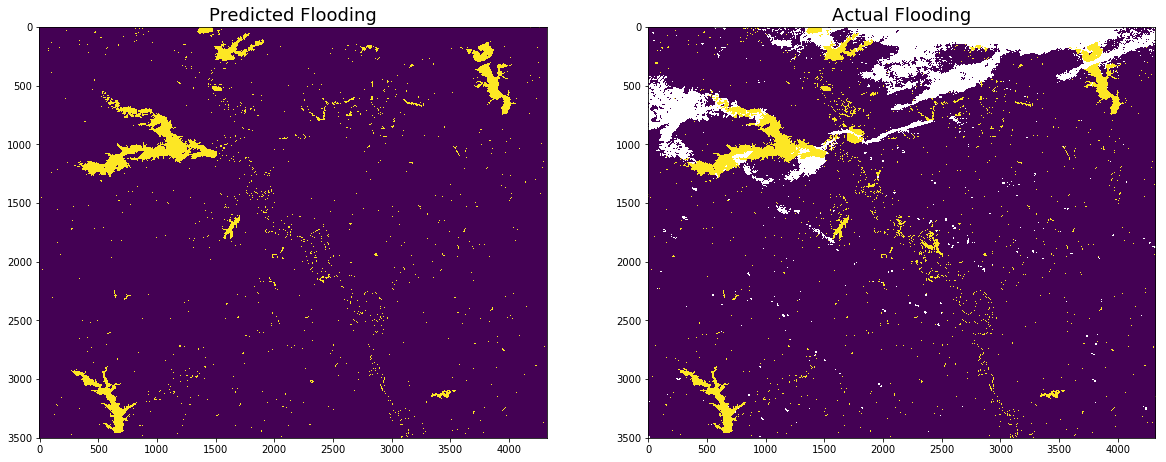

In [11]:
# Reshape predicted values back into image band
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(2).shape # Shape of full original image
        arr_empty = np.zeros(shape) # Create empty array with this shape

output_image = arr_empty
rows, cols = zip(data_ind)
output_image[rows, cols] = output_data

plt.figure(figsize=(20,30))
columns = 2
images = [output_image, data[:,:,14]]
titles = ['Predicted Flooding','Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

#### Should I add weights to cross entropy to account for imbalanced dataset?

https://stats.stackexchange.com/questions/197273/class-balancing-in-deep-neural-network

https://stackoverflow.com/questions/35155655/loss-function-for-class-imbalanced-binary-classifier-in-tensor-flow

https://datascience.stackexchange.com/questions/30930/accuracy-and-loss-dont-change-in-cnn-is-it-over-fitting


## Fill cloud gaps using trained CNN
### Load and pre-process cloud gap image

In [30]:
# Stack exported tifs from GEE into one multiband tif
import rasterio
import os

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

file_list = []
for file in listdir_fullpath(path_clouds):
    if file.endswith('.tif'):
        file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order

#=========== Want to rearrange the order of files so that target feature is last

# Create list of features with target feature (flooded) last
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])
    
# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# Make new directory for stacked tif if it doesn't already exist
try:
    os.mkdir(path_clouds+'/stack')
except OSError:
    pass

# Remove stack file if already exists
try:
    os.remove(path_clouds + '/stack/stack.tif')
except OSError:
    pass

with rasterio.open(path_clouds + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


#=======================================================================================

# Preprocess the data

# Get local image
with rasterio.open(path_clouds + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN

# Convert -999999 to None
data[data == -999999] = np.nan

# Get indices of non-nan values. These are the indices of the original image array
# data_ind = np.where(data[:,:,1] != None)
data_ind = np.where(~np.isnan(data[:,:,1]))
row, col = zip(np.where(~np.isnan(data[:,:,1]))) # image row and col of values
len(*row)


#=======================================================================================

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
data_vector.shape

# Hold out a fraction of the labeled data for validation.
# training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
# training_data = data_vector[0:training_size,:]
# validation_data = data_vector[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands.
data_mean = training_data[:,0:14].mean(0)
data_std = training_data[:,0:14].std(0)

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


### Predict on cloud gaps using trained and imported CNN

In [40]:
# Need to read up on checkpoints and saved models
# https://www.tensorflow.org/guide/checkpoints

# Prepare feed dictionary

new_input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
new_labels = tf.placeholder(tf.float32, shape=[None])

normalized = (input - data_mean) / data_std

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(model_path+model_name+'-1000.meta')
#     saver.restore(sess, tf.train.latest_checkpoint(model_path+'./'))
    saver.restore(sess, model_path+'checkpoint.ckpt')
    
    pred_data = outputs.eval({input: data_vector[:,0:14]})
    # graph = tf.get_default_graph()
    # print([n.name for n in graph.as_graph_def().node])

INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn2/checkpoint.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for C:/Users/ipdavies/CPR/data/models/cnn2/checkpoint.ckpt
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 497, in start
    self.io_loop.start()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 759, in _run_callback
    ret = callback()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-dc320c8a2a84>", line 46, in <module>
    saver = tf.train.Saver()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1284, in __init__
    self.build()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1296, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1333, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 400, in _AddRestoreOps
    restore_sequentially)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 832, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1546, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for C:/Users/ipdavies/CPR/data/models/cnn2/checkpoint.ckpt
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [38]:
model_path+'checkpoint'

'C:/Users/ipdavies/CPR/data/models/cnn2/checkpoint'

### Performance metrics on cloud gaps

In [45]:
# Confusion matrix
print_cm(metrics.confusion_matrix(data_vector[:,14], pred_data)/len(pred_data)*100, labels=['notFlooded','Flooded'])

# Reshape predicted values back into image band
with rasterio.open(path_clouds + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(2).shape # Shape of full original image
        arr_empty = np.zeros(shape) # Create empty array with this shape

output_image = arr_empty
rows, cols = zip(data_ind)
output_image[rows, cols] = pred_data

plt.figure(figsize=(20,30))
columns = 2
images = [output_image, data[:,:,14]]
titles = ['Predicted Flooding','Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
plt.show()

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
